In [7]:
#Mounting gdrive if working on gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
#Processing Packages
import pandas as pd
import numpy as np
import os
from datetime import datetime

#Visualisation Packages
import matplotlib.pyplot as plt
import seaborn as sns
#Pacakges
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim import corpora, models
from sklearn.manifold import TSNE

from pprint import pprint

import pickle

In [9]:
 import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

# Load Data
project_home = "/content/gdrive/My Drive/USML Project"
records_data = pd.read_csv(os.path.join(project_home, "all_trials.csv"))
mesh_data = pd.read_csv(os.path.join(project_home, "MESH_Terms_v2.csv"))
punc ='!"#$%&\'()*+,./:;<=>?@[\\]^`{|}~'

In [ ]:
# Filtering Records Data for 2019 and 2020
for i in range(records_data.shape[0]):
  if(type(records_data['start_date'][i]) != float):
    if(',' in records_data['start_date'][i]):
      records_data['start_date'][i] = datetime.strptime(records_data['start_date'][i],"%B %d, %Y").strftime("%Y")
    else:
      records_data['start_date'][i] = datetime.strptime(records_data['start_date'][i],"%B %Y").strftime("%Y")

records_data =  records_data[(records_data.start_date.isin(['2020','2019','2018']))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
len(records_data)

75163

In [12]:
# Process clinical records data
records_data = records_data[['id','title','brief_summary','detailed_description']] # Subset columns
records_data = records_data.replace(np.nan, '', regex=True) # Replace Null values with empty strings
records_data['article'] = records_data['title'].str.cat(records_data['brief_summary'], sep=" ").str.cat(records_data['detailed_description'], sep=" ") # Create Concatenated text using all data
records_data = records_data.drop(['title','brief_summary','detailed_description'], axis=1)
records_data['article'] = records_data['article'].str.lower()   ## lower case
records_data.article =  records_data.article.str.translate(str.maketrans('','',punc))   # Remove punctuations except '-', '_'
records_data.article =  records_data.article.str.strip()    # Remove whitespaces


In [13]:
# Lemmatizing function for inputted text (Not Required)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [14]:
# Preprocessing steps after tokenization of document text.
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append((token))
    return result

In [15]:
# Set Stemming vocabulary to english
stemmer = SnowballStemmer('english')

In [16]:
# Processed the 
processed_docs = records_data['article'].map(preprocess)

In [17]:
len(processed_docs)

75163

In [18]:
#Create Bag of Words
dictionary = gensim.corpora.Dictionary(processed_docs)
#Filter out the extremities
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [19]:
len(dictionary)

18675

In [20]:
# Calculate the # of dictionary wirds in each trial document(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [21]:
#Apply TF-IDF oin the corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [22]:
len(corpus_tfidf)

75163

In [23]:
k=[10,20,30,40,50,60,70,80,90,100]
coherence_values = []
model_list = []
for num_topics in k:
    model = gensim.models.LdaMulticore(corpus_tfidf,num_topics=num_topics, id2word=dictionary, passes=2,workers=4)
    model_list.append(model)
    coherencemodel =gensim.models.CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [24]:

for m, cv in zip(k, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4872
Num Topics = 20  has Coherence Value of 0.561
Num Topics = 30  has Coherence Value of 0.5008
Num Topics = 40  has Coherence Value of 0.5193
Num Topics = 50  has Coherence Value of 0.5176
Num Topics = 60  has Coherence Value of 0.5215
Num Topics = 70  has Coherence Value of 0.535
Num Topics = 80  has Coherence Value of 0.5145
Num Topics = 90  has Coherence Value of 0.5079
Num Topics = 100  has Coherence Value of 0.519


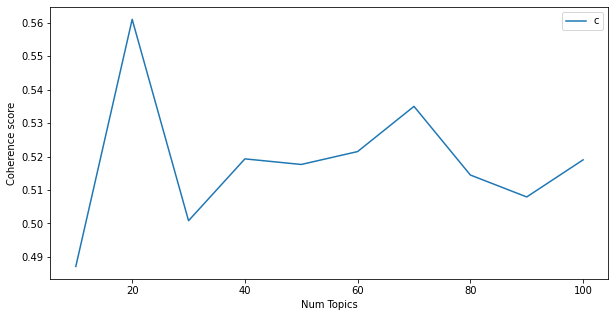

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting Number of Topics vs Coherence 
plt.figure(figsize=(10,5))
plt.plot(k, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig(os.path.join(project_home,'Topic_Modelling_TopicvsCoherenceGraph.jpg'))

In [26]:
model_list

In [27]:
k=[4,8,12,16,20]
coherence_values = []
model_list = []
for num_topics in k:
    model = gensim.models.LdaMulticore(corpus_tfidf,num_topics=num_topics, id2word=dictionary, passes=2)
    model_list.append(model)
    coherencemodel =gensim.models.CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

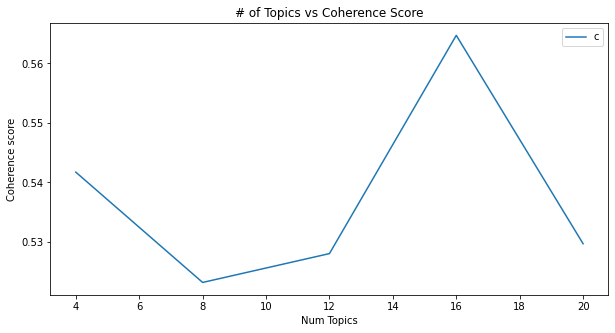

In [28]:
#Plotting Number of Topics vs Coherence 
plt.figure(figsize=(10,5))
plt.plot(k, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("# of Topics vs Coherence Score")
plt.savefig(os.path.join(project_home,'Topic_Modelling_TopicvsCoherenceGraph_Optimal.jpg'))
plt.show()

In [29]:
for m, cv in zip(k, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.5417
Num Topics = 8  has Coherence Value of 0.5232
Num Topics = 12  has Coherence Value of 0.528
Num Topics = 16  has Coherence Value of 0.5647
Num Topics = 20  has Coherence Value of 0.5297


In [30]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.007*"pain" + 0.007*"surgery" + 0.005*"postoperative" + 0.004*"anesthesia" '
  '+ 0.004*"block" + 0.003*"surgical" + 0.003*"operative" + 0.002*"pressure" + '
  '0.002*"opioid" + 0.002*"analgesia"'),
 (1,
  '0.010*"stimulation" + 0.008*"exercise" + 0.007*"muscle" + 0.006*"brain" + '
  '0.006*"pain" + 0.005*"training" + 0.005*"knee" + 0.005*"motor" + '
  '0.004*"tdcs" + 0.004*"strength"'),
 (2,
  '0.019*"vaccine" + 0.009*"vaccination" + 0.007*"hepatitis" + 0.006*"iron" + '
  '0.006*"immunogenicity" + 0.006*"safety" + 0.006*"virus" + 0.005*"dose" + '
  '0.005*"smoking" + 0.005*"influenza"'),
 (3,
  '0.010*"healthy" + 0.009*"single" + 0.009*"subjects" + 0.009*"dose" + '
  '0.008*"tablets" + 0.007*"label" + 0.007*"open" + 0.007*"formulation" + '
  '0.007*"crossover" + 0.007*"oral"'),
 (4,
  '0.014*"aortic" + 0.013*"valve" + 0.007*"mitral" + 0.006*"ablation" + '
  '0.005*"transcatheter" + 0.005*"aneurysm" + 0.004*"stent" + '
  '0.004*"aneurysms" + 0.004*"regurgitation" + 0.004*"sten

In [31]:
#clusters of documents in a 2D space using t-SNE

In [32]:
corpus_tfidf

In [33]:
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus_tfidf]):
    x=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for items in row_list:
        d=items[0]
        x[d-1]=items[1]
    topic_weights.append(x)


In [34]:
arr = pd.DataFrame(topic_weights)

In [35]:
arr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.020542,0.020542,0.691876,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542,0.020542
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165075,0.000000,0.000000,0.000000,0.134244,0.000000,0.582937
2,0.010313,0.357209,0.010313,0.010313,0.010313,0.010313,0.010313,0.010314,0.243159,0.010313,0.010313,0.010313,0.216419,0.010313,0.010313,0.059457
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238861,0.000000,0.000000,0.308713,0.381708
4,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.010761,0.838581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75158,0.272639,0.000000,0.000000,0.020963,0.000000,0.000000,0.000000,0.000000,0.630408,0.000000,0.000000,0.011861,0.000000,0.000000,0.000000,0.000000
75159,0.558447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.326257,0.024808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826765,0.000000,0.000000,0.053878,0.000000,0.000000,0.000000,0.000000
75161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.366234,0.000000,0.000000,0.000000,0.519091,0.020308,0.000000,0.000000,0.000000,0.000000


In [36]:
# Dominant topic number in each doc
topic_num = np.array(arr.idxmax(axis=1))

In [37]:
topic_num

array([ 2, 15,  1, ...,  8, 10,  0])

In [38]:
tsne_model = TSNE(n_components=2, random_state=0, angle=.99, init='pca',perplexity=50)

In [39]:
tsne_lda = tsne_model.fit_transform(arr)

In [40]:
topic_num

array([ 2, 15,  1, ...,  8, 10,  0])

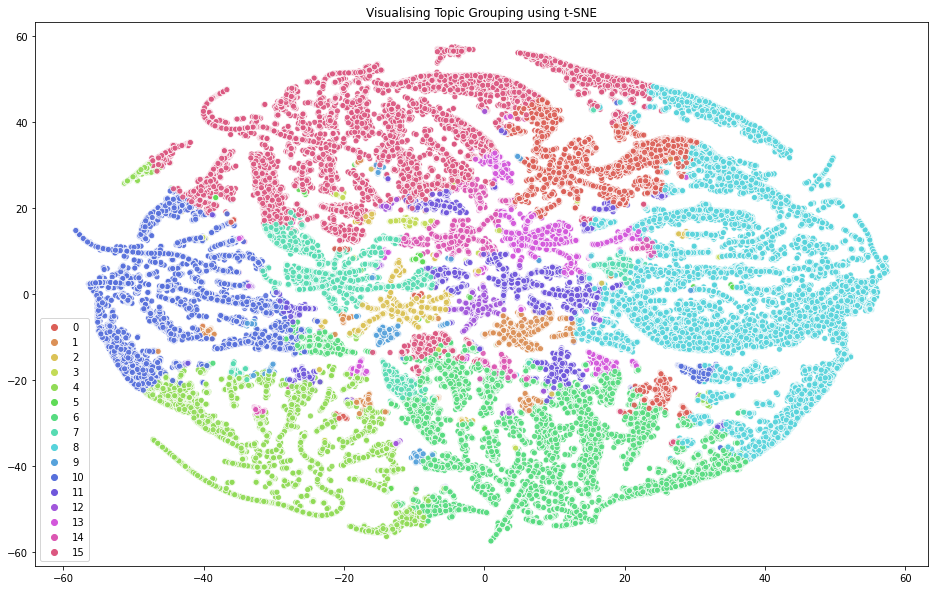

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(tsne_lda[:,0],tsne_lda[:,1],hue=topic_num,legend="full",alpha=0.9,palette=sns.color_palette("hls", 16))
plt.title("Visualising Topic Grouping using t-SNE")
plt.savefig(os.path.join(project_home,"LDA_TSNe.jpg"))

In [49]:
dictionary_file = os.path.join(project_home,"dictionary.pickle")
model_file = os.path.join(project_home,"opt_model.pickle")

In [50]:
dictionary

In [51]:
optimal_model

In [52]:
pickle.dump(dictionary, open(dictionary_file,"wb"))
pickle.dump(optimal_model, open(model_file,"wb"))
